# Алгоритмы кластеризации

Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [1]:
import random
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)


## Реализация алгоритма

Необходимо выбрать и реализовать самостоятельно один из следующих алгоритмов кластеризации:
* Агломеративная иерархическая кластеризация с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)
* DBSCAN. (параметры - epsilon, min_pts) - нужно самостоятельно разобрать и применить критерий качества для DBSCAN
* OPTICS(\*). (параметры - epsilon, min_pts)
* Gaussian Mixture Model(\*\*) с использованием maximum a-posteriori для выбора кластера (параметр - k)

(\*) - алгоритм не был разобран на занятии. Выбирайте этот пункт только если уверенно умеете программировать и хотите разобраться с более сложной идеей, чем DBSCAN  
(\*\*) - алгоритм не был разобран на занятии, задание повышенной сложности. Выбирайте этот пункт только если хотите разобраться со сложным математическим обоснованием и точно уверены, что сможете запрограммировать и отладить.

## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

Выбран DBSCAN, как наиболее хороший и одновременно простой метод.

Ниже приведен псевдокод из лекции с habr

```
DBSCAN(D, eps, MinPts) {
	C = 0
   for each point P in dataset D {
      if P is visited
         continue next point
      mark P as visited
      NeighborPts = regionQuery(P, eps)
      if sizeof(NeighborPts) < MinPts
         mark P as NOISE
      else {
         C = next cluster
         expandCluster(P, NeighborPts, C, eps, MinPts)
      }
   }
}

expandCluster(P, NeighborPts, C, eps, MinPts) {
   add P to cluster C
   for each point Q in NeighborPts { 
      if Q is not visited {
         mark Q as visited
         QNeighborPts = regionQuery(Q, eps)
         if sizeof(QNeighborPts) >= MinPts
            NeighborPts = NeighborPts joined with QNeighborPts
      }
      if Q is not yet member of any cluster
         add Q to cluster C
   }
}

regionQuery(P, eps)
   return all points within P eps-neighborhood (including P)
```


In [7]:
from  scipy.spatial.distance import cdist

In [76]:
def regionQuery(x, X, eps):
    """
    Функция для возврата порядковых номеров точек внутри области вокруг точки Х
    """
    d =  cdist(x, X)
#     print(d[0])
    return [item[0] for item in np.argwhere(d[0]<eps)]

In [77]:
regionQuery(np.array([[0,0]]), np.array([[1,1],[2,2],[3,3]]), 4)

[0, 1]

In [57]:
import collections

In [81]:
from sklearn.base import BaseEstimator, ClusterMixin

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    def __init__(self, epsilon, min_pts):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        
        self.epsilon = epsilon
        self.min_pts = min_pts
        
        self.noise_cluster = 0
        self.cluster = None
        self.visited = None
#         return self
        
    def fit(self, X, y=None):
        """
        Use data matrix x to compute model parameters
        """
        
        self.visited = np.zeros(len(X))
        self.cluster = np.zeros(len(X))
        C = self.noise_cluster  #следующий кластер
        for i, x in enumerate(X):
            if self.visited[i]==1:
                continue
            
            self.visited[i]=1
#             print(x)
            neighboors = regionQuery([x], X, self.epsilon) #функция определена выше
            
            if(len(neighboors)<=self.min_pts):
                continue #по умолчанию у нас все кластеры - шумовые
            
            C = C + 1
            self.expand_cluster(i, neighboors, C, X)
        
        return self

    def expand_cluster(self, x, neighboors, C, X):
        self.cluster[x] = C
        while len(neighboors)>0:
            n = neighboors.pop()
            if self.visited[n]==1:
                continue
            
            self.visited[n]=1
            
            next_neighboors = regionQuery([X[n]], X, self.epsilon)
            
            if len(next_neighboors)>self.min_pts:
                neighboors.extend(next_neighboors)
            
            if self.cluster[n]==0:
                self.cluster[n]=C
    
    def predict(self, X):
        """
        Using computed model parameters predict cluster
        for all objects from x
        
        Так как могут прийти другие объекты - классификацию выполняем по min_pts точкам - каких кластеров в них больше, 
        если меньше min_pts - считаем шумом
        """
        cluster = np.zeros(len(X))
        for i, x in enumerate(X):
            neighboors = regionQuery(n, X, self.epsilon)
            if len(neighboors)<=self.min_pts:
                continue
            c = collections.Counter()
            for n in neighboors:
                c[self.cluster[n]]+=1
            
            current_cluster = max(c, key=c.get)
            cluster[i] = current_cluster
        
        return cluster
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.cluster

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

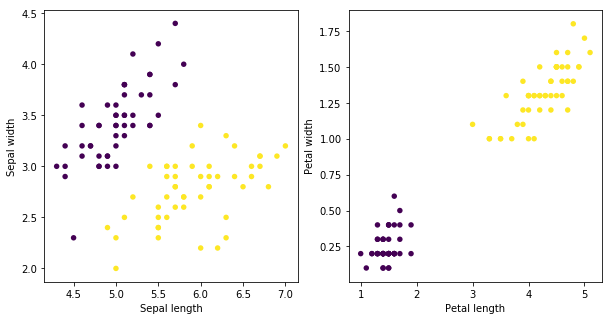

In [82]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

In [83]:
pred_iris = Clustering(0.7, 5).fit_predict(x_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 0.96


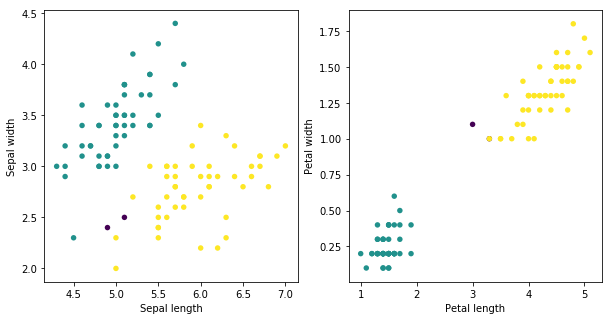

In [84]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=pred_iris, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=pred_iris, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Подобрать параметры модели с использованием эвристик и критериев качества. 

Критерий локтя:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров, а так же при необходимости изменить этот код (для DBSCAN). На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров. Возможно, необходимо построить такую визуализацию несколько раз.

Количество соседей возьмем 7

Цель - сделать функцию, которая возвращает отсортированный список epsilon для 7 ближайших точек

In [156]:
def mean_by_pts(X, pts):
    lst = []
    for x in X:
        d =  cdist([x], X)[0]
#         print (d[:6])
#         print (np.mean(sorted(d, reverse=False)[0:pts]))
        lst.append( np.mean(sorted(d, reverse=False)[0:pts]))
    return sorted(lst)

In [163]:
mean_by_pts(x_iris, 7)[:10]

[0.11984150081516089,
 0.12438203288938636,
 0.13346309703783724,
 0.1365782561759297,
 0.14924039213839652,
 0.14924039213839654,
 0.15169143321345072,
 0.1522892744995878,
 0.1548843390538747,
 0.15682980657381299]

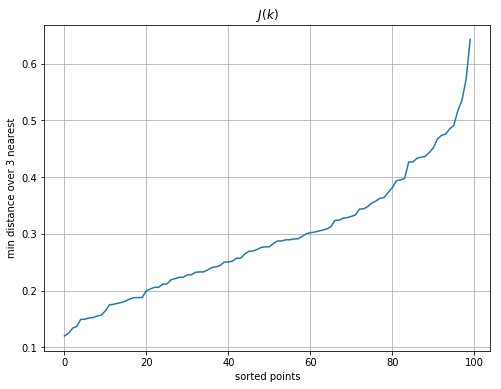

In [164]:
    
pl.figure(figsize=(8, 6))
pl.plot(mean_by_pts(x_iris, 
                   7))
pl.title("$J(k)$")
pl.ylabel("min distance over 3 nearest")
pl.xlabel("sorted points")
pl.grid()
pl.show()

Около 0,55

Adjusted Rand index for iris is: 0.86


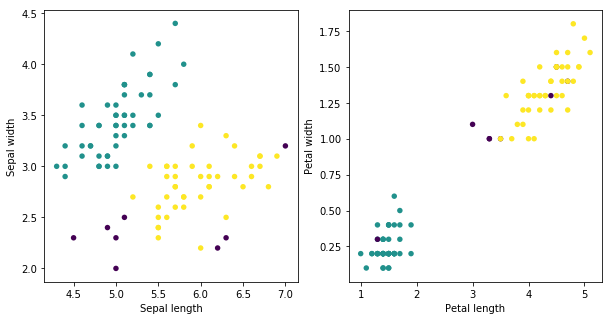

In [165]:
pred_iris = Clustering(0.55, 7).fit_predict(x_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=pred_iris, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=pred_iris, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Далее необходимо кластеризовать с помощью реализованного алгоритма данные, используемые для демонстраций на предыдущих занятиях. Предлагается сделать сравнение с реализацией из sklearn.

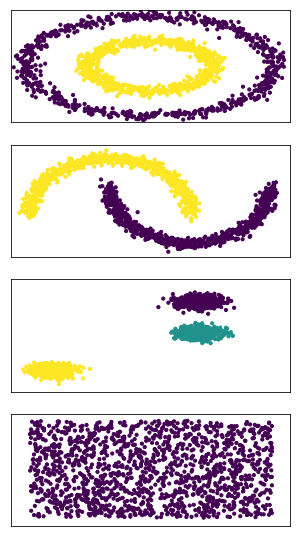

In [141]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

plt.figure(figsize=(2 + 3, 9.5))

data = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    pred = Clustering(0.3, 5).fit_predict(X)

    # plot
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], c = pred, s=10)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

plt.show()

## Дополнительное задание (не является обязательным)


Примените три любых алгоритма кластеризации из библиотеки sklearn на выбранном вами датасете (реальные данные, датасет с kaggle и пр.). Желательно выбрать легко интерпретируемые данные - например, данные о товарах или пользователях, где есть название, пол, возраст, а так же любые другие легко воспринимаемые признаки.

После применения алгоритма покажите в каждом кластере несколько представителей и проинтерпретируйте результат.